# <center>Using Large Language Models</center>

In this notebook we will demonstrate a new means of solving a common analysis/ data science task: understanding and labeling text. The tasks of summarizing and labeling texts are present in many analyst tasks and are an area where there has been an explosion of recent work in AI on. For this notebook, we are going to be leveraging some of the recent work in [Large Language Models (LLMs)](https://machinelearningmastery.com/what-are-large-language-models/) to solve these ML challenges. Once again, we want to get after a workflow that resembles:

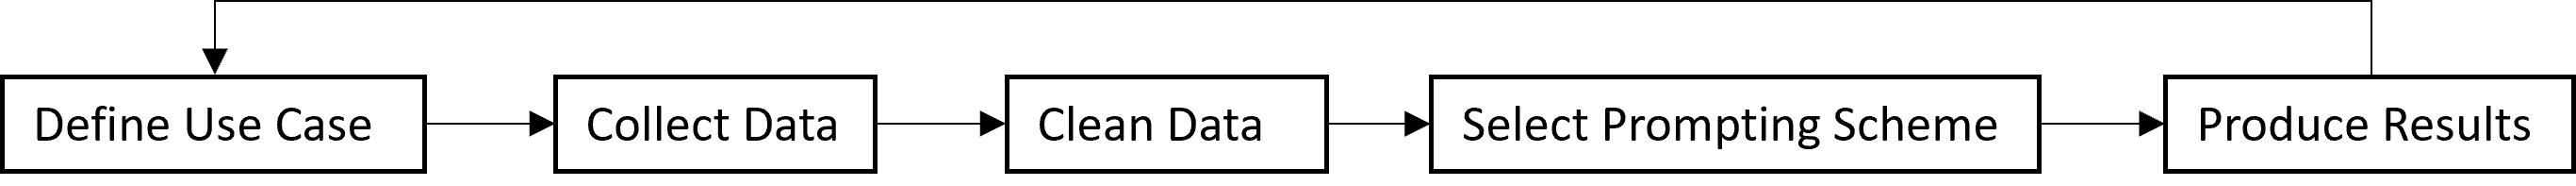

For this notebook, we will cover the following:
1. Installing packages and setting up the environment
2. Creating a data set
3. Summarizing and describing a corpus of text
4. Zero-shot text labeling
5. Using Prompt Engineering for more complex analyses of text data

----Addendum Section-----

6. Additional ways (i.e. prompting) to summarize and describe text

# 1. Import necessary Packages and Set up the Environment
- Import necessary packages, most especially [HuggingFace](https://huggingface.co/), Torch, [LangChain](https://python.langchain.com/en/latest/index.html), and [BERTopic](https://maartengr.github.io/BERTopic/index.html)
- we will also import and install Google's API in order to get some data related to YouTube Comments

In [ ]:
! pip install google-api-python-client
! pip install langchain --user
! pip install openai --user
! pip install bertopic
# The following are for getting certain LLMs to work
! pip install einops
! pip install tiktoken

In [116]:
import os, re, numpy as np, pandas as pd
from tqdm import tqdm
from collections import Counter
from scipy import stats
from hdbscan import HDBSCAN
import umap
import openai
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from bertopic import BERTopic
from bertopic.representation import MaximalMarginalRelevance
from bertopic.representation import LangChain
from bertopic.representation import TextGeneration

from sentence_transformers  import SentenceTransformer
from transformers import pipeline
import torch

from googleapiclient.discovery import build

from langchain import OpenAI, PromptTemplate, LLMChain, HuggingFacePipeline, FewShotPromptTemplate
from langchain.llms import AzureOpenAI
from langchain.chains.summarize import load_summarize_chain
from langchain.chains.question_answering import load_qa_chain
from langchain.docstore.document import Document
from langchain.chains.mapreduce import MapReduceChain
from langchain.text_splitter import RecursiveCharacterTextSplitter

from matplotlib import pyplot as plt
import seaborn as sns

# 2. Create a data set

For this demonstration, we are going to do an analysis of social media data. More specifically, we want to look at the comments on a YouTube video; imagine that you are a public affairs/social media analyst and want to get 'reflections' on a recent recruiting campaign video. We want to understand what is being talked about in the comments of the YouTube video and how the video is being received. As a follow on, we want to be able to classify those comments into a series of custom labels, which has the potential of being a machine learning task.

The tasks that we will need to do in this section are:

- import comments from YouTube videos. The following functions are for scraping the comments of a youtube video, given the video id
- look at some examples

In [5]:
def get_video_comments(video_id, api_key):
    """Retrieve comments for a YouTube video.

    This function retrieves comments for a YouTube video specified by the given video ID using the YouTube Data API.
    
    Parameters:
    video_id (str): The ID of the YouTube video for which to retrieve comments.
    api_key (str): The API key to access the YouTube Data API.

    Returns:
    list: A list of dictionaries containing information about each comment. Each dictionary has the following keys:
        - 'id' (str): The ID of the comment.
        - 'comment' (str): The text content of the comment.
        - 'author' (str): The display name of the comment's author.
        - 'author_channel' (str): The channel ID of the comment's author.
        - 'like_count' (int): The number of likes on the comment.
        - 'published_at' (str): The publish date and time of the comment.
        - 'conversation_id' (str): The ID of the comment thread or conversation.
    
    """
    # empty list for storing reply
    replies = []
 
    # creating youtube resource object
    youtube = build('youtube', 'v3',
                    developerKey=api_key)
 
    # retrieve youtube video results
    video_response=youtube.commentThreads().list(
        part='snippet',
        maxResults=100,
        videoId=video_id
    ).execute()
 
    # iterate video response
    results = []
    while video_response:
       
        # extracting required info
        # from each result object
        for item in video_response['items']:
           
            datum = {}
            datum['id'] = item['id']
            datum['comment'] = item['snippet']['topLevelComment']['snippet']['textOriginal']
            datum['author'] = item['snippet']['topLevelComment']['snippet']['authorDisplayName']
            datum['author_channel'] = item['snippet']['topLevelComment']['snippet']['authorChannelId']['value']
            datum['like_count'] = item['snippet']['topLevelComment']['snippet']['likeCount']
            datum['published_at'] = item['snippet']['topLevelComment']['snippet']['publishedAt']
            datum['coversation_id'] = item['id']
            results.append(datum)
            if item['snippet']['totalReplyCount'] > 0:
                results.extend(get_all_top_level_comment_replies(item['id'], [], None)) 
 
        # Again repeat
        if 'nextPageToken' in video_response:
            video_response = youtube.commentThreads().list(
                    part = 'snippet',
                    pageToken = video_response['nextPageToken'],
                    videoId = video_id
                ).execute()
        else:
            return results

In [6]:
def get_all_top_level_comment_replies(top_comment_id, replies, token):
    
    # creating youtube resource object
    youtube = build('youtube', 'v3',
                    developerKey=api_key)
    
    replies_response=youtube.comments().list(part='snippet',
                                               maxResults=100,
                                               parentId=top_comment_id,
                                               pageToken=token).execute()

    for item in replies_response['items']:
        datum = {}
        datum['id'] = item['id']
        datum['comment'] = item['snippet']['textOriginal']
        datum['author'] = item['snippet']['authorDisplayName']
        datum['author_channel'] = item['snippet']['authorChannelId']['value']
        datum['like_count'] = item['snippet']['likeCount']
        datum['published_at'] = item['snippet']['publishedAt']
        datum['coversation_id'] = top_comment_id
        replies.append(datum)

    if "nextPageToken" in replies_response: 
        return get_all_top_level_comment_replies(top_comment_id, replies, replies_response['nextPageToken'])
    else:
        return replies

In [7]:
# Possible YouTube videos that we will look at for Analysis

video_id = "Lwx-2R9swDg" # Be All You Can Be - U.S. Army's new brand trailer - U.S. Army
#video_id = "-ZMzfihqOkQ" # What Army Snipers Go Through At Sniper School - insider business
#video_id = "nV8UZJNBY6Y" # Adele - The Final Carpool Karaoke
#video_id = "kLMMxgtxQ1Y" # GOP- Beat Biden AI-generated images

If scraping new data run the following...

In [64]:
with open("youtube_credentials.txt") as f:
    api_key = f.read()

In [8]:
comments = get_video_comments(video_id, api_key)

In [9]:
comments_df = pd.DataFrame(comments)

In [10]:
# save data
comments_df.to_csv("video_comments_"+video_id+".csv")

... Else just read in previously scraped data. For the U.S. Army Recruitment video, a previous scrape can be found at [this Google Drive](https://drive.google.com/file/d/1vkZo7pyQllgrDZURC8_ZhYPKVAeyhqxh/view?usp=drive_link)

In [8]:
# load data
comments_df = pd.read_csv("video_comments_"+video_id+".csv", index_col=0)

Now, let's have a quick look at what we got back form scraping comments

In [9]:
comments_df.shape

(5086, 7)

In [10]:
comments_df.head()

,id,comment,author,author_channel,like_count,published_at,coversation_id
0,UgyZqW0x5zhxhYxWj0F4AaABAg,What will would come out with and say about th...,Shea Synott,UCq9iU_VTUeCnVKnr_vdOwXw,0,2023-05-28T23:18:11Z,UgyZqW0x5zhxhYxWj0F4AaABAg
1,UgzN65JCJ-_xTi48zJF4AaABAg,We don't need anymore imbred Ukrainian soldier...,Shea Synott,UCq9iU_VTUeCnVKnr_vdOwXw,0,2023-05-27T07:44:16Z,UgzN65JCJ-_xTi48zJF4AaABAg
2,UgzOjmN9_qlyirQ6QCB4AaABAg,If you are dumb enough to join the military be...,Mike Stanton,UCsQQR5LeDxNgmV1Gzp9roGg,1,2023-05-26T22:40:04Z,UgzOjmN9_qlyirQ6QCB4AaABAg
3,UgzXfU7YSB65CxFeJSF4AaABAg,"""Thanks to the terrible power of our Internati...",theycallme_nightmaster,UC6QQIz9FS03tGZDUieRiRRg,2,2023-05-26T09:33:48Z,UgzXfU7YSB65CxFeJSF4AaABAg
4,Ugxu-OImhl2ZP2zgWUR4AaABAg,Yooooo... Lol I went to Basic at Ft. Leonardwo...,Mr. Grown Gamer,UCidfBxbswcgs7Y1aJsjZMfQ,0,2023-05-26T05:48:29Z,Ugxu-OImhl2ZP2zgWUR4AaABAg


# 3. Set up a Large Language Model

Since we are looking to create a quick ML solution, we will want to use more of a general purpose model, which can handle a wide array of tasks in a wide array of data sets, with no training or data labeling involved. So, we need to either stand up or link to an LLM to do this

In [21]:
# import OpenAI Key, if you have one and want to use OpenAI's LLMs

with open("personal_openai_key.txt") as f:
    open_api_key = f.read()
    
os.environ["OPENAI_API_KEY"] = open_api_key

In [22]:
# Use OpenAI from Azure, for those that have Azure Credits

with open("aci_openai_credentials.txt") as f:
    open_api_base, open_api_key = f.read().split("\n")

os.environ["OPENAI_API_TYPE"] = "azure"
os.environ["OPENAI_API_VERSION"] = "2022-12-01"
os.environ["OPENAI_API_BASE"] = open_api_base
os.environ["OPENAI_API_KEY"] = open_api_key

In [23]:
# Specify the LLM to use

#llm = OpenAI(temperature=0)
#llm = AzureOpenAI(deployment_name="gpt35", model_name="text-davinci-003")
llm = HuggingFacePipeline.from_model_id(model_id="declare-lab/flan-alpaca-gpt4-xl", task = 'text2text-generation', device=0,
                                      model_kwargs={"max_length":500, "no_repeat_ngram_size":2})

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# 3. Preprocess the Text

Before diving into the machine learning-based analysis of the text, we first need to do some light text preprocessing. It would also be good to visualize all of the comments to see if there are any patterns or outliers in the text. So, in this section we will do the following:

- remove URLs from text, as the generally don't provide any semantic information. Removing mentions (i.e.`@`) can also help for this as well.
- visualize the comments to see if there are any distinct patterns or clusters in the data using embeddings and a dimensionality reduction technique, in this case [UMAP](https://umap-learn.readthedocs.io/en/latest/).

In [11]:
def process_text(text): 
    
    text = text.replace("&amp;", "and").replace("&gt;", ">").replace(
        "&lt;", "<")
    
    #remove urls
    text = re.sub(r'http\S+|www\S+', "", text)
    
    #change new lines into spaces
    text = re.sub("\n", " ", text)
    text = re.sub("\n\n", " ", text)
    
    return text

In [12]:
# preprocess the text to remove mentions and tame the newline characters

comments_df['clean_comment'] = comments_df["comment"].apply(lambda x : process_text(x))

In [13]:
# Create vector embeddings of the comments

embedding_model = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v2', device='cuda:0')
# embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

comments_df['embedding'] = comments_df["clean_comment"].apply(lambda x : embedding_model.encode(x))

In [14]:
# Reduce the dimensionality of the embeddings so that we can visualize them

X_vis = umap.UMAP(n_neighbors =30, n_components=2, metric="cosine", min_dist=0.0).fit_transform(np.array(comments_df['embedding'].values.tolist()))
vis_df = pd.DataFrame(X_vis, columns=['x', 'y'])

<Axes: xlabel='x', ylabel='y'>

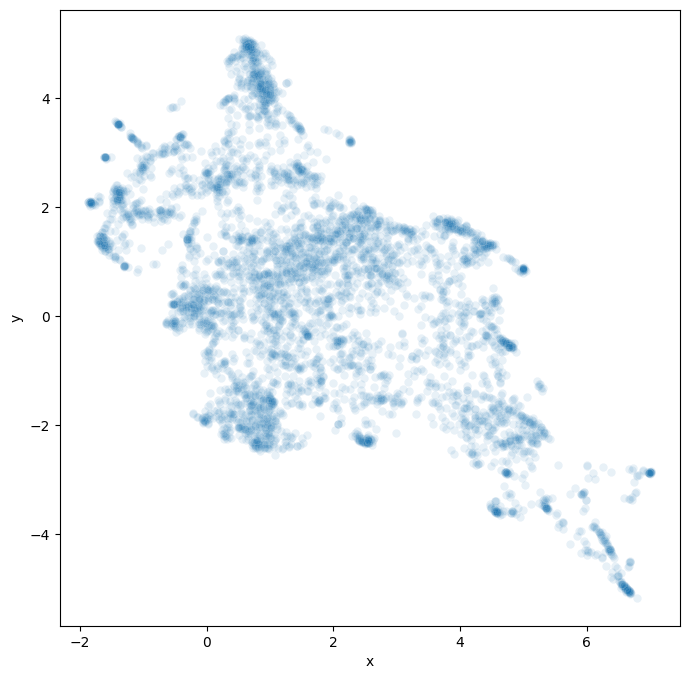

In [15]:
# visualize the dimensionality-reduced embeddings of the text

plt.figure(figsize=(8,8))
sns.scatterplot(data=vis_df, x='x', y='y', alpha=0.1)

In the previous cells, we did a couple of things. First, we cleaned the data. Second, we used [Sentence Transformers](https://www.sbert.net/) to embed each of the comments into a vector space. Then, we reduced the dimensionality of those vectors into 2-d so that we could visualize all the comments. The use of pre-trained sentence embeddings is the first use of our no-train machine learning models. In this case, we are using a pre-trained machine learning model to map text into a vector (i.e. embed the data).

From this initial look at the data, there are some more regions of clusteriness - but no clearly separated clusters - and no clear outlier comments that we need to drop from the data set. 

# 4. Describe the Comments

To describe the comments, we want to do a two-step procedure: group text together by "topics" and describe those topics. This will be the second use of no-train machine learning models.
- use [BERTopic](https://maartengr.github.io/BERTopic/index.html) to group together like articles, since any given corpus of text will often feature multiple comments
- use a ['representation'](https://maartengr.github.io/BERTopic/getting_started/representation/representation.html) layer with BERTopic to describe the different topics. This representation layer can be a number of things, including text summarization by an LLM.

Note that BERTopic has _a lot_ of variations that one can do, to include [incorporating](https://maartengr.github.io/BERTopic/index.html#variations) labels into the topic modeling, or text clustering, procedure.

In [16]:
# Sepcify the topic modeling and summarization

topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model = umap.UMAP(n_neighbors=30, n_components=50, min_dist=0.0, metric='cosine'),
    hdbscan_model = HDBSCAN(min_cluster_size=int(len(comments_df)/100), metric='euclidean', cluster_selection_method='eom', prediction_data=True),
    #nr_topics= "auto",
    representation_model = MaximalMarginalRelevance(diversity=0.3)
)

In [17]:
topics, probs = topic_model.fit_transform(comments_df["clean_comment"])

In [18]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1860,-1_for_they_my_this,"[for, they, my, this, not, all, your, army, pe...",[Government don't give a fuck about it's own c...
1,0,621,0_and_army_for_military,"[and, army, for, military, us, country, your, ...","[Fun Fact: Did you know that in the US Army, i..."
2,1,445,1_israel_for_jews_can,"[israel, for, jews, can, israeli, fight, all, ...","[i don’t want die for israel, I will die for I..."
3,2,413,2_maxwell_your_and_what,"[maxwell, your, and, what, know, like, out, br...","[@The Gem don't do it man, everyone I know wh..."
4,3,340,3_oy_shut_goy_lol,"[oy, shut, goy, lol, good, what, fucking, nope...","[Shut it down THE GOYIM KNOW, The goyim know. ..."
5,4,289,4_russia_ukraine_russian_china,"[russia, ukraine, russian, china, we, russians...",[@Adolf Hitler Germany invaded Poland to expan...
6,5,276,5_white_for_men_this,"[white, for, men, this, whites, military, them...",[It's in jest. The US Army is trying to pull ...
7,6,196,6_ad_this_commercial_army,"[ad, this, commercial, army, ads, slogan, new,...",[This is a good ad. I'm glad they went back to...
8,7,195,7_zogbot_100_lmfao_bankers,"[zogbot, 100, lmfao, bankers, correct, isreal,...","[Zogbot, Zogbot, Zogbot lmao]"
9,8,155,8_comments_section_hope_these,"[comments, section, hope, these, here, you, bo...","[This comment section gives me so much hope, T..."


<Axes: xlabel='x', ylabel='y'>

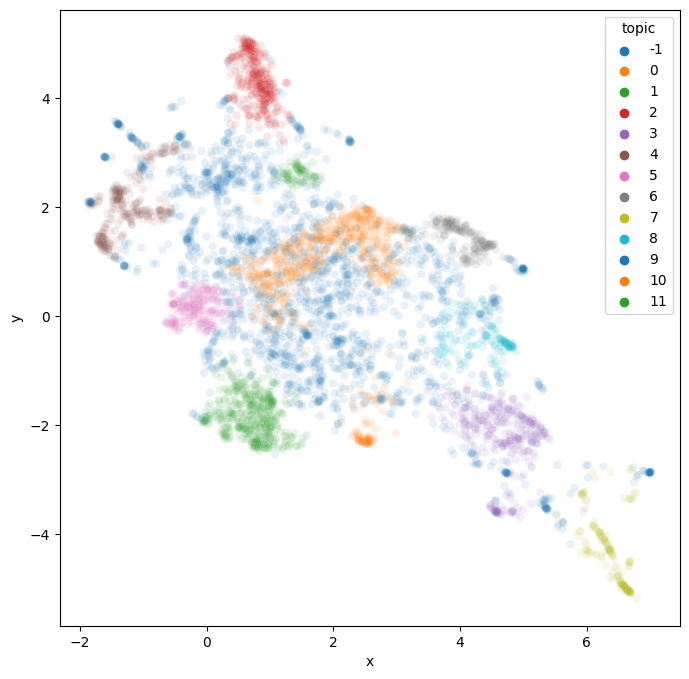

In [19]:
plt.figure(figsize=(8,8))
vis_df['topic'] = topics
sns.scatterplot(data=vis_df, x='x', y='y', hue='topic', palette='tab10', alpha=0.1)

This gives us some idea of the comments section, but we can do better. Instead of trying to guess what the major themes are in data based upon keywords, lets summarize the blocks of comments instead. To do this, we'll leverage a Large Language Model with prompting. It is at this point that we'll be leveraging [LangChain](https://python.langchain.com/en/latest/index.html) in order to create prompt templates and to abstract the prompts from the LLM, so that we can substitute in LLMs at will for any given prompting scheme.

In [24]:
prompt = '''These texts are comments made by various users to a U.S. Army Recruiting video. Please give a brief summarization of the comments as they relate to the video.'''

In [25]:
# Use the load_summarize_chain for the summarization task

chain = load_summarize_chain(llm, chain_type="stuff")

In [26]:
# Sepcify the topic modeling and summarization by a LangChain to an LLM

topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model = umap.UMAP(n_neighbors=30, n_components=50, min_dist=0.0, metric='cosine'),
    hdbscan_model = HDBSCAN(min_cluster_size=int(len(comments_df)/100), metric='euclidean', cluster_selection_method='eom', prediction_data=True),
    #nr_topics= "auto",
    representation_model = LangChain(chain, prompt=prompt)
)

In [27]:
topics, probs = topic_model.fit_transform(comments_df["clean_comment"])

Token indices sequence length is longer than the specified maximum sequence length for this model (853 > 512). Running this sequence through the model will result in indexing errors


In [28]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1729,"-1_""SilverbackSenpai: What do you mean by netw...","[""SilverbackSenpai: What do you mean by networ...",[@SEnergy Except the US didn't annex any of th...
1,0,979,0_The user wrote a negative review of the Army...,[The user wrote a negative review of the Army'...,"[""BE ALL YOU CAN BE"" was, is and always will b..."
2,1,458,"1_""I will not die for Israel.""___","[""I will not die for Israel."", , , , , , , , , ]","[I will not die for Israel., I will not die fo..."
3,2,416,2_The tweets discuss the controversy surroundi...,[The tweets discuss the controversy surroundin...,[@Maxwell.Vondeen no we’re not you got clowned...
4,3,326,"3_Kevin Johnston, a US politician, is addressi...","[Kevin Johnston, a US politician, is addressin...",[@Kevin Johnston What I will say is that there...
5,4,300,4_The comment section of a YouTube video promo...,[The comment section of a YouTube video promot...,[It's in jest. The US Army is trying to pull ...
6,5,263,5_The message is an attempt to shut down comme...,[The message is an attempt to shut down commen...,"[The goyim know.. SHUT IT DOWN!, Oy Vey! the G..."
7,6,168,6_The tweet is a joke about zogbots.___,"[The tweet is a joke about zogbots., , , , , ,...","[Zogbot, zogbot, Zogbot lmao]"
8,7,119,7_The comment section is based.___,"[The comment section is based., , , , , , , , , ]","[These comments are so based., Based comment s..."
9,8,98,8_The conversation revolves around the idea of...,[The conversation revolves around the idea of ...,[@ScuffedRyanGosling Convincing someone they h...


In [29]:
for i in topic_model.get_topic_info()['Name']:
    print(i)

-1_"SilverbackSenpai: What do you mean by network? I don't know many people because my life has sort of had constant situations where I've been way way more isolated than most people. All my present and former coworkers are just poor restaurant workers like me, and all of those places churn through people so fast that I wouldn''d even be able to get in contact with plenty of them again if I tried to. I’ve had been getting off of social media over the past few years because of too many creepy cyber stalking type of incidents that really creeped me out. That’s why I was thinking maybe joining the military for something like help paying for a home, or law school, medical school or ... something else similar."___
0_The user wrote a negative review of the Army's new "Be All You Can Be" recruiting campaign, citing negative experiences and PTSD. They criticized the military for being mismanaged and not providing opportunities for growth.___
1_"I will not die for Israel."___
2_The tweets discu

In [30]:
rep_docs = topic_model.get_representative_docs()

In this first section, we now have an idea of what the general topics are for the discussion of the YouTube video. Through the use of pre-trained models, namely an LLM and a smaller sentence embedding  model, we were able to convert the text into vectors, cluster those vectors into 'topics' and then summarize the topics. 

For the Army Recruitment video, we are seeing a fair amount of anitsemtic content, anti-diversity content, content critical of the Army and the way it treats people, as well as some people that seem to like the return to the old "Be all you can be" type of slogan.

# 5. Zero-shot Text Classification

Having summarized the comments to the YouTube video, we now want to classify these comments into some meaningful labels, based upon what types of comments we want to find and what kinds of comments likely exist in the data. To do this, we will once again use a no-train, pre-trained model combined with some free-text labels that we can specify; we are going to do a [zero-shot text classification](https://huggingface.co/tasks/zero-shot-classification)!

In [35]:
classifier = pipeline(model="facebook/bart-large-mnli", task="zero-shot-classification", device=0, batch_size=64)

In [36]:
labels = ["supportive of service in the army", "antisemitic", "anti-ukraine", "anti-diversity", "anti-war", "anti-government", "white supremacy",
          "anti-immigration", "against service in the military", "arguing with someone", "anti-vaccination", "sexual misconduct", "neutral comment"]

In [37]:
# Screen for blank comments

comments_list = [i for i in comments_df['clean_comment'].to_list() if len(i) >0]

In [38]:
# Classify the actual comments

cls_results = classifier(comments_list, candidate_labels = labels, multi_label=True)

The previous set of blocks are all that is needed to do text classification, for any given set of labels we would like to apply to the text. No manual labeling required and labels can be mutli-word text strings themselves, which can help with more semantically nuanced labels 🙌

Now, lets look at the results

In [39]:
# look at some of the results

cls_results[0]

{'sequence': "What will would come out with and say about the us army having contracts in relation to pathogen weapons with the Ukraine health system. The who said Ukraine health system has been under severe pressure. Pressure meaning to cause persuasion ob or intimidation. Now I've seen the leaked army document. I'm saving it to my phone. And I've sent the document to your presidents email.",
 'labels': ['anti-ukraine',
  'arguing with someone',
  'anti-government',
  'anti-war',
  'against service in the military',
  'supportive of service in the army',
  'anti-diversity',
  'antisemitic',
  'anti-vaccination',
  'white supremacy',
  'neutral comment',
  'anti-immigration',
  'sexual misconduct'],
 'scores': [0.21546247601509094,
  0.17126572132110596,
  0.16462543606758118,
  0.04008156806230545,
  0.018012449145317078,
  0.017138073220849037,
  0.013309621252119541,
  0.0051497966051101685,
  0.004333726596087217,
  0.003373403800651431,
  0.0027958867140114307,
  0.002772966166958

In [40]:
# Get out the most probable labels

zero_shot_labels = [res['labels'][np.argmax(res['scores'])] for res in cls_results]
label_counts = pd.DataFrame.from_dict(Counter(zero_shot_labels), orient='index', columns=['count'])
label_counts['label'] = label_counts.index

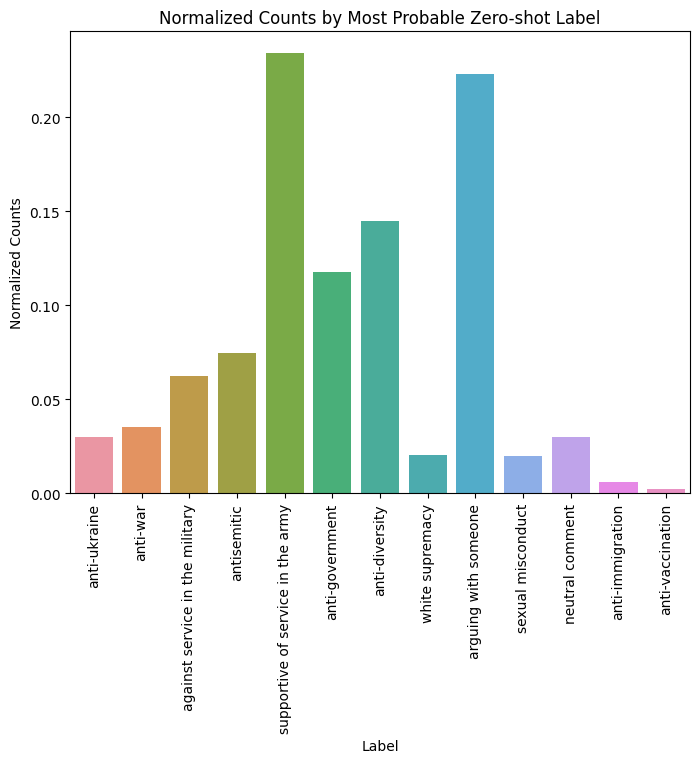

In [41]:
# Visualize the distribution of the most common labels in the comments

# Normalize the counts
label_counts['Normalized Counts'] = label_counts['count'] / label_counts['count'].sum()

# Create a bar plot using seaborn
plt.figure(figsize=(8, 6))
sns.barplot(data=label_counts, x='label', y='Normalized Counts')
plt.xlabel('Label')
plt.xticks(rotation=90)
plt.ylabel('Normalized Counts')
plt.title('Normalized Counts by Most Probable Zero-shot Label')
plt.show()

In [42]:
# Get the probable labels for each comment (each comment could have more than one probable label, or none)

threshold = 0.5
zero_shot_labels = [[res['labels'][i] for i in range(len(res['scores'])) if res['scores'][i] >=threshold] for res in cls_results]

# Create a set to store all unique strings in the sublists
unique_strings = set()
for sublist in zero_shot_labels:
    unique_strings.update(sublist)

# Initialize a dictionary to store the frequencies
frequencies = {string: [] for string in unique_strings}

# Count the occurrences of strings in each sublist
for sublist in zero_shot_labels:
    string_counts = {string: sublist.count(string) for string in unique_strings}
    for string, count in string_counts.items():
        frequencies[string].append(count)

# Create the dataframe
probable_labels_df = pd.DataFrame(frequencies)

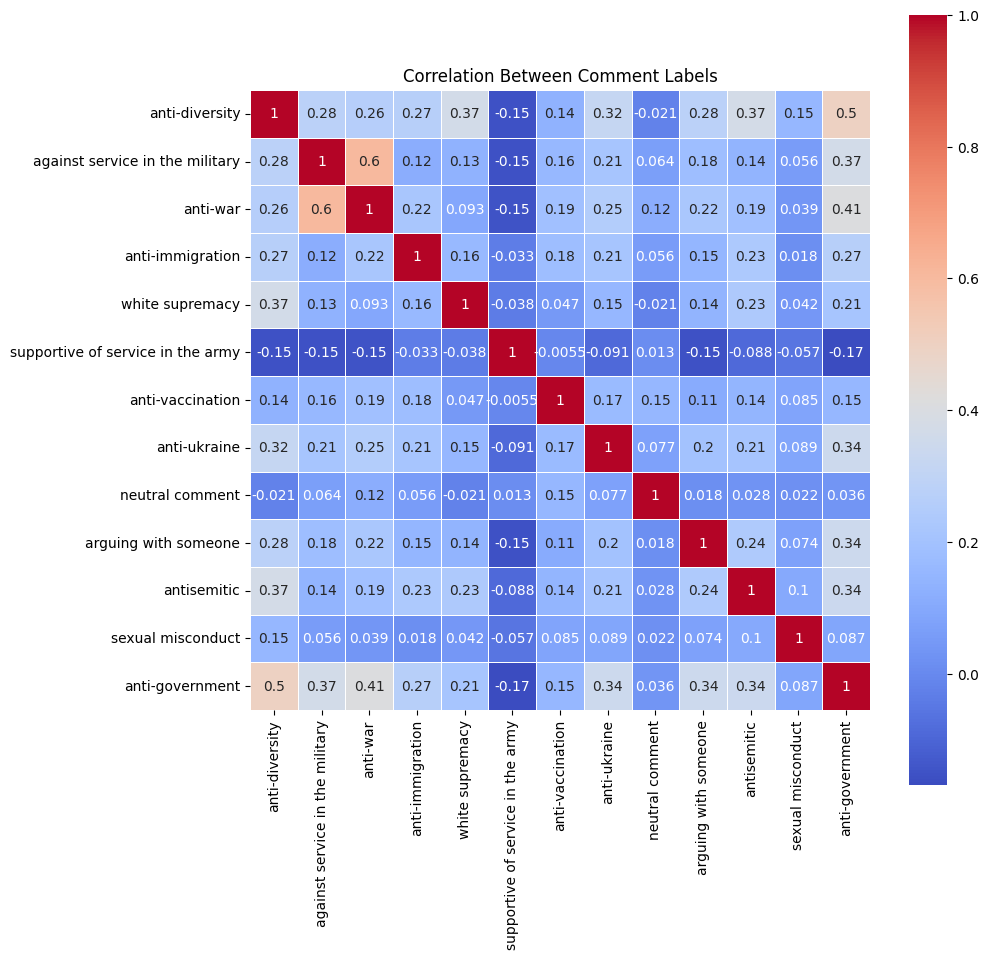

In [43]:
# Visualize the correlation between the different labels of the comments

# Calculate the point biserial correlation for each pair of columns
correlations = {}
for col1 in probable_labels_df.columns:
    for col2 in probable_labels_df.columns:
        if col1 != col2:
            corr, _ = stats.pointbiserialr(probable_labels_df[col1], probable_labels_df[col2])
            correlations[(col1, col2)] = corr

# Create a correlation matrix
corr_matrix = pd.DataFrame(index=probable_labels_df.columns, columns=probable_labels_df.columns)
for col1 in corr_matrix.columns:
    for col2 in corr_matrix.columns:
        corr_matrix.loc[col1, col2] = correlations.get((col1, col2), 1.0)


# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix.astype(float), annot=True, cmap='coolwarm', linewidths=0.5, square=True)
plt.title('Correlation Between Comment Labels')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

From this section, first there actually does seem to be fair amount of comments of that are supportive of the U.S Army and arguing going on in the comments section. Given that there is also a fair number of comments from topics like antisemitism and anti-diversity categories, it may mean there is a fair amount of trolling on the video taking place. 

Finally, it is also interesting to note that by characterizing the ML task as a multi-label one, we can see where certain labels intersect, like anti-government and anti-diversity, which points to wider narratives and belief structures among some of those making comments on the film.

# 6. Using an LLM and Prompting for More Nuanced, Difficult Tasks

In this section, we are going to use [prompt engineering](https://www.mihaileric.com/posts/a-complete-introduction-to-prompt-engineering/) or prompting combined with an LLM to tackle more difficult ML tasks, again without the need for labeling or training a model. In this case, we want to classify the [stance](https://www.sciencedirect.com/science/article/pii/S0306457321000960) of the comments towards the YouTube video in question. We will look at the following:

- just asking an LLM for the stance of a comment
- using few shot prompting for stance
- using few shot prompting with reasoning for stance
- dealing with large blocks of text

In [44]:
# For the demo, we are going to sample some comments from the possible comments

comments = np.random.choice(comments_list, size=60)

In [45]:
# We are also going to add in sentiment, in order to compare it to stance to see why we need stance

sid = SentimentIntensityAnalyzer()

sentiment_labels = [sid.polarity_scores(x)['compound'] for x in comments]

In [46]:
stance_df = pd.DataFrame(zip(comments, sentiment_labels), columns=['text', 'sentiment'])

### Asking the LLM for the Stance

In [53]:
# Create aa generic prompt template

template = '''
The following YouTube comment is a comment on a U.S. Army Recruitment video. Please give the stance of the comment toward the YouTube video as FOR, AGAINST, or NEUTRAL. Only return the stance.

comment: {comment}
'''

stance_prompt = PromptTemplate(
    input_variables=["comment"],
    template=template
)

In [54]:
stance_labels = [llm(stance_prompt.format(comment=x)) for x in comments]

In [55]:
stance_df['stance'] = stance_labels

### Few-shot Prompting (AKA In-context Learning) for the Stance

In [59]:
# Create an example template

template = '''
comment: {comment}
stance: {stance}
'''

example_prompt = PromptTemplate(
    input_variables=["comment", "stance"],
    template=template
)

In [80]:
# Give some examples

examples = [
    {'comment':rep_docs[0][0],
     'stance': 'FOR'},
    {'comment':rep_docs[1][1],
     'stance': 'AGAINST'},
    {'comment':rep_docs[3][1],
     'stance': 'NEUTRAL'},
    {'comment':rep_docs[4][1],
     'stance': 'AGAINST'},
    {'comment':rep_docs[5][1],
     'stance': 'AGAINST'},
    {'comment':rep_docs[7][2],
     'stance': 'NEUTRAL'},
    {'comment':rep_docs[9][0],
     'stance': 'FOR'}
]

In [81]:
# Take a look at an example

print(example_prompt.format(**examples[0]))


comment: "BE ALL YOU CAN BE" was, is and always will be the Army's slogan. It's known and still spoken around the world! This is a far superior commercial, than the last "WOKE"  commercial! That was just a shameful embarrassment!!! The Marines have a simple formula a slogan and a uniform. They  haven't changed it in decades  " The Few, The Proud, The Marines"  Dispite their many different occupations, they all look, think and act the same, (Pride Valor, Honor and Discipline), they are all "US MARINES "!!  Once a Marine always a Marine!   The US. Army is the 2nd oldest institution in the nation, even older than the country itself.  The Contentilal Army suffered the labor pains and gave birth to the nation.  Simply just tell all the Valor, the Honor, the Discipline  and Warriors Creed of who we are, what we stand for.  When Freedom calls, when Justice  is challenged with oppression, We " The US Army" are the light in the darkness,  the Guardians of Liberty! Then and only then show the d

In [82]:
# Put together the examples and the example template, along with a prefix and suffix, to create a few-shot pormpt

prefix = """
The following are examples of the stance of a comment to a U.S. Army Recruiting Video on YouTube. Examples:
"""

suffix = '''
Now, classify each of the following comments into the possible stances of FOR, AGAINST, or NEUTRAL toward a U.S. Army Recruiting Video on YouTube. Only return the stance:

comment: {comment}
stance:
'''

few_shot_prompt_template = FewShotPromptTemplate(
    examples=examples,
    example_prompt=example_prompt,
    prefix=prefix,
    suffix=suffix,
    input_variables=["comment"],
    example_separator="\n"
)

In [83]:
# Take a look at the few shot prompt

print(few_shot_prompt_template.format(comment=comments_list[0]))


The following are examples of the stance of a comment to a U.S. Army Recruiting Video on YouTube. Examples:


comment: "BE ALL YOU CAN BE" was, is and always will be the Army's slogan. It's known and still spoken around the world! This is a far superior commercial, than the last "WOKE"  commercial! That was just a shameful embarrassment!!! The Marines have a simple formula a slogan and a uniform. They  haven't changed it in decades  " The Few, The Proud, The Marines"  Dispite their many different occupations, they all look, think and act the same, (Pride Valor, Honor and Discipline), they are all "US MARINES "!!  Once a Marine always a Marine!   The US. Army is the 2nd oldest institution in the nation, even older than the country itself.  The Contentilal Army suffered the labor pains and gave birth to the nation.  Simply just tell all the Valor, the Honor, the Discipline  and Warriors Creed of who we are, what we stand for.  When Freedom calls, when Justice  is challenged with oppress

In [84]:
few_shot_stance_labels = [llm(few_shot_prompt_template.format(comment=x)) for x in comments]

In [85]:
stance_df['few_shot_stance'] = few_shot_stance_labels

### Few-shot Prompting with Reasoning

In [94]:
# Create an example template

template = '''
comment: {comment}
stance: {stance}
reason: {reason}
'''

example_prompt = PromptTemplate(
    input_variables=["comment", "stance", "reason"],
    template=template
)

In [95]:
# Give some examples

examples = [
    {'comment':rep_docs[0][0],
     'stance': 'AGAINST',
     'reason': "This comment is generally in favor of the video because it is more simialr to a be all you can be commercial that worked well for Army recruitment in the past"
    },
    {'comment':rep_docs[1][1],
     'stance': 'AGAINST',
     'reason': "This comment is against the recruiting add as it implies that the U.S. Army, and more generally the U.S. government is controlled by Israel, and that one should not die for Israel or Jewsih people."
    },
    {'comment':rep_docs[3][1],
     'stance': 'NEUTRAL',
     'reason': "This comment is neutral as it talks about the history of World War Two and is not directed toward nor relevant for the U.S. Army recruiting video."
    },
    {'comment':rep_docs[4][1],
     'stance': 'AGAINST',
     'reason': "This comment is against the U.S. Army recruitment video as the video feature people of different skin colors and the comment argues that by doing it discriminates against white people."
    }
]

In [96]:
# Take a look at an example

print(example_prompt.format(**examples[0]))


comment: "BE ALL YOU CAN BE" was, is and always will be the Army's slogan. It's known and still spoken around the world! This is a far superior commercial, than the last "WOKE"  commercial! That was just a shameful embarrassment!!! The Marines have a simple formula a slogan and a uniform. They  haven't changed it in decades  " The Few, The Proud, The Marines"  Dispite their many different occupations, they all look, think and act the same, (Pride Valor, Honor and Discipline), they are all "US MARINES "!!  Once a Marine always a Marine!   The US. Army is the 2nd oldest institution in the nation, even older than the country itself.  The Contentilal Army suffered the labor pains and gave birth to the nation.  Simply just tell all the Valor, the Honor, the Discipline  and Warriors Creed of who we are, what we stand for.  When Freedom calls, when Justice  is challenged with oppression, We " The US Army" are the light in the darkness,  the Guardians of Liberty! Then and only then show the d

In [104]:
# Put together the examples and the example template, along with a prefix and suffix, to create a few-shot pormpt

prefix = """
The following are examples of the stance of a comment to a U.S. Army Recruiting Video on YouTube with the reason for that stance. Examples:
"""

suffix = '''
Now, classify each of the following comments into the possible stances of FOR, AGAINST, or NEUTRAL toward a U.S. Army Recruiting Video on YouTube and give the reason for why you classified it as that stance. Only return the stance and the reason, separated by a comma, in the form of "stance, reason".

comment: {comment}
stance:
reason:
'''

few_shot_prompt_with_reason_template = FewShotPromptTemplate(
    examples=examples,
    example_prompt=example_prompt,
    prefix=prefix,
    suffix=suffix,
    input_variables=["comment"],
    example_separator="\n"
)

In [105]:
# Take a look at the few shot prompt

print(few_shot_prompt_with_reason_template.format(comment=comments_list[0]))


The following are examples of the stance of a comment to a U.S. Army Recruiting Video on YouTube with the reason for that stance. Examples:


comment: "BE ALL YOU CAN BE" was, is and always will be the Army's slogan. It's known and still spoken around the world! This is a far superior commercial, than the last "WOKE"  commercial! That was just a shameful embarrassment!!! The Marines have a simple formula a slogan and a uniform. They  haven't changed it in decades  " The Few, The Proud, The Marines"  Dispite their many different occupations, they all look, think and act the same, (Pride Valor, Honor and Discipline), they are all "US MARINES "!!  Once a Marine always a Marine!   The US. Army is the 2nd oldest institution in the nation, even older than the country itself.  The Contentilal Army suffered the labor pains and gave birth to the nation.  Simply just tell all the Valor, the Honor, the Discipline  and Warriors Creed of who we are, what we stand for.  When Freedom calls, when Jus

In [106]:
few_shot_stance_with_reason_labels = [llm(few_shot_prompt_with_reason_template.format(comment=x)) for x in comments]

In [111]:
stance_df['few_shot_stance_with_reason'] = [item.split('stance: ')[1].split(' reason: ')[0].strip() for item in few_shot_stance_with_reason_labels]
stance_df['few_shot_reason_for_stance'] =  [item.split('reason: ')[1].strip() for item in few_shot_stance_with_reason_labels]

### Dealing with Large Chunks of Text when Doing Few-Shot Prompting

In [113]:
# Create a summarizer prompt and text splitter for long documents

map_prompt = """
Write a concise summary of the following comment. Be sure to keep any information that indicates the author's feelings toward the U.S. Army.
"{text}"
CONCISE SUMMARY:
"""
map_prompt_template = PromptTemplate(template=map_prompt, input_variables=["text"])
summary_chain = load_summarize_chain(llm=llm, chain_type='map_reduce', map_prompt=map_prompt_template)

text_splitter = RecursiveCharacterTextSplitter(separators=["\n\n", "\n", " "], chunk_size=1000, chunk_overlap=0, length_function = len)

In [118]:
# Iterate through each text and check if it is too long. If so, split and summarize it. Then feed them to the LLM for stance classification.

few_shot_stance_labels = []

for text in tqdm(comments):
    if llm.get_num_tokens(text) > 1024:
        docs = text_splitter.create_documents([text])
        text = summary_chain.run(docs)
    few_shot_stance_labels.append(llm(few_shot_prompt_template.format(comment=text)))

100%|██████████| 60/60 [01:02<00:00,  1.04s/it]


# Conclusion

In this tutorial we demonstrated a number of techniques, leveraging pre-trained models, and LLMs in particular, to accomplish machine learning tasks on text data. In particular, given the task of understanding the comment space on a YouTube video, we could summarize the main topics and describe the comment space. We could also classify all of the comments into a custom set of labels, with no training or labeling of data (although one should note the zero-shot text classifcation often is not perfect and frequently messes things up when there is a lot of subtelty, coded language, or sarcasm). Finally, we also showed how we could use LLMs, with prompting to solve harder ML problems like stance classifcation on text, once again with no (or maybe minimal) data labeling and no training.

# Addendum

In this final section, we'll show a couple of alternative prompting schemes for describing the topics making up a textual space. Option 1 is custom prompt incorporating documents (i.e. comments) and keywords (i.e. the top topic words). Option 2 is using a question and answer prompt scheme.

### Option 1: Custom Prompt Scheme

In [96]:
prompt = """
I have collection of YouTube comments to a U.S. Army Recruiting video that contains the following comments: \n[DOCUMENTS]
The collection is described by the following keywords: [KEYWORDS]

Based on the above information, can you give a brief descriprion of the collection?
"""

In [97]:
generator = pipeline(model="declare-lab/flan-alpaca-gpt4-xl", max_length=500, no_repeat_ngram_size=2, device=0)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [98]:
# Sepcify the topic modeling and summarization

topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model = umap.UMAP(n_neighbors=30, n_components=50, min_dist=0.0, metric='cosine'),
    hdbscan_model = HDBSCAN(min_cluster_size=int(len(comments_df)/100), metric='euclidean', cluster_selection_method='eom', prediction_data=True),
    #nr_topics= "auto",
    representation_model = [MaximalMarginalRelevance(diversity=0.3), TextGeneration(generator, prompt=prompt)]
)

In [99]:
topics, probs = topic_model.fit_transform(comments_df["clean_comment"])

In [100]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1578,-1_The collection of YouTube comments is a res...,[The collection of YouTube comments is a respo...,[@SEnergy Except the US didn't annex any of th...
1,0,1121,0_The collection of YouTube comments is a resp...,[The collection of YouTube comments is a respo...,"[""BE ALL YOU CAN BE"" was, is and always will b..."
2,1,446,1_The collection of YouTube comments is a resp...,[The collection of YouTube comments is a respo...,"[I will not die for Israel, I will die for Isr..."
3,2,421,2_The collection of YouTube comments is a resp...,[The collection of YouTube comments is a respo...,"[@The Gem don't do it man, everyone I know wh..."
4,3,326,3_The collection of YouTube comments is a resp...,[The collection of YouTube comments is a respo...,[They hate your for being White but they want ...
5,4,314,4_The collection of YouTube comments discusses...,[The collection of YouTube comments discusses ...,[@Андрей Власов Neat. How does that justify Ru...
6,5,241,5_The collection of YouTube comments contains ...,[The collection of YouTube comments contains o...,"[Shut it down THE GOYIM KNOW, Oy Vey! the Goyi..."
7,6,165,6_The collection of YouTube comments contains ...,[The collection of YouTube comments contains j...,"[Zogbot, zogbot, Zogbot lmao]"
8,7,135,7_The collection of YouTube comments is relate...,[The collection of YouTube comments is related...,"[These comments are so based., Based comment s..."
9,8,104,8_The collection of YouTube comments contains ...,[The collection of YouTube comments contains m...,"[Be All You Can Be!, Be all you can be., Be al..."


In [101]:
for i in topic_model.get_topic_info()['Name']:
    print(i)

-1_The collection of YouTube comments is a response to 'This was so gay.', expressing disapproval towards the use of the word woke in the video. The comments also discuss the reality of being in an Army, which is not always clean and involves struggles and death.___
0_The collection of YouTube comments is a response to promoting the U.S. Army's recruitment video. Some of the comments are critical of its message, highlighting the sacrifice of Marines who died in combat. Others praise the Army for its slogan, "BE ALL YOU CAN BE," and compare the previous "WOKE" commercial to an embarrassment. The last comment, which references Soros and the WEF, suggests that surviving the military is an act of betrayal of one'' country. Overall, the collection expresses varying opinions on the effectiveness of Army recruitment efforts and their potential to promote patriotism and unity.___
1_The collection of YouTube comments is a response to 'Be All You Can Be (For Israel)', referring to the U.S. Army 

### Option 2: Q&A Prompt Scheme

In [108]:
prompt = '''These texts are comments about a U.S. Army Recruiting video. What is the theme of these comments? Please give a brief description.'''

In [103]:
# llm = OpenAI(temperature=0)
llm = HuggingFacePipeline.from_model_id(model_id="declare-lab/flan-alpaca-gpt4-xl", task = 'text2text-generation', device=0,
                                       model_kwargs={"max_length":500, "no_repeat_ngram_size":2})

chain = load_qa_chain(llm=llm, chain_type="stuff")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [109]:
# Sepcify the topic modeling and summarization

topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model = umap.UMAP(n_neighbors=30, n_components=50, min_dist=0.0, metric='cosine'),
    hdbscan_model = HDBSCAN(min_cluster_size=int(len(comments_df)/100), metric='euclidean', cluster_selection_method='eom', prediction_data=True),
    #nr_topics= "auto",
    representation_model = LangChain(chain, prompt=prompt)
)

In [110]:
topics, probs = topic_model.fit_transform(comments_df["clean_comment"])

In [111]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1610,-1_The theme of these comments is the U.S. Arm...,[The theme of these comments is the U.S. Army ...,[​​​@Justin Williams I get where you're coming...
1,0,1161,0_The theme of these comments is disapproval a...,[The theme of these comments is disapproval an...,"[So they remove ""that"" It used to be: Be, all..."
2,1,455,1_The theme of these comments is support for t...,[The theme of these comments is support for th...,"[I will not die for Israel, I will not die for..."
3,2,407,2_The theme of these comments is disapproval a...,[The theme of these comments is disapproval an...,"[@The Gem don't do it man, everyone I know wh..."
4,3,374,3_The theme of these comments is anti-military...,[The theme of these comments is anti-military ...,[It's in jest. The US Army is trying to pull ...
5,4,284,4_The theme of these comments is anti-Russian ...,[The theme of these comments is anti-Russian s...,[​​@I Stand With Russia (Z O V) Do you actuall...
6,5,244,5_The theme of these comments is anti-Semitism...,[The theme of these comments is anti-Semitism ...,"[The goyim know, shut it down., Oy Vey! the Go..."
7,6,161,6_The theme of these comments is humor and sup...,[The theme of these comments is humor and supp...,"[Zogbot, Zogbot, Zogbot lmao]"
8,7,109,7_The theme of these comments is helpful.___,"[The theme of these comments is helpful., , , ...","[These comments are so based., Based comment s..."
9,8,106,"8_The theme of these comments is ""Believe in y...","[The theme of these comments is ""Believe in yo...","[Be all you can be., Be All You Can Be!, Be al..."


In [112]:
for i in topic_model.get_topic_info()['Name']:
    print(i)

-1_The theme of these comments is the U.S. Army Recruiting video.___
0_The theme of these comments is disapproval and rejection of the U.S. Army's recruitment efforts.___
1_The theme of these comments is support for the U.S. Army and its mission to protect and defend Israel.___
2_The theme of these comments is disapproval and criticism of the U.S. Army Recruiting video.___
3_The theme of these comments is anti-military recruitment and the exodus of white males from the U.S. Army.___
4_The theme of these comments is anti-Russian sentiment and antisemitism.___
5_The theme of these comments is anti-Semitism and antipathy towards the Jewish community.___
6_The theme of these comments is humor and support for the U.S. Army Recruiting video.___
7_The theme of these comments is helpful.___
8_The theme of these comments is "Believe in yourself and your abilities."___
9_The theme of these comments is anti-government and anti Trump protests.___
10_The theme of these comments is criticism of the 